<a href="https://colab.research.google.com/github/MohamadHBaydoun/COMP9444/blob/MohamadBranch/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MohamadHBaydoun/COMP9444.git

Cloning into 'COMP9444'...
remote: Enumerating objects: 1529, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1529 (delta 1), reused 1 (delta 0), pack-reused 1523 (from 1)
Receiving objects: 100% (1529/1529), 1.01 GiB | 27.58 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Updating files: 100% (1754/1754), done.


In [3]:
# 0. Import packages
import os
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [18]:
# 1. Create model


# USE RESIDUAL NEURAL NETWORKS AND FCN'S WITH 1X1 CONVOLUTIONS AND UPSAMPLING OPERATIONS
import torch

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6):
        super(UNet, self).__init__()

        # Downsampling (Encoder)
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv3 = self.double_conv(128, 256)

        # Upsampling (Decoder)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = self.double_conv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5 = self.double_conv(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        x3 = self.conv2(x2)
        x4 = self.pool2(x3)

        # Bottleneck
        x5 = self.conv3(x4)

        # Decoder with skip connections
        x6 = self.up1(x5)
        x6 = torch.cat([x3, x6], dim=1)
        x7 = self.conv4(x6)

        x8 = self.up2(x7)
        x8 = torch.cat([x1, x8], dim=1)
        x9 = self.conv5(x8)

        return self.final_conv(x9)

# Create model instance
model = UNet(in_channels=3, out_channels=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)


UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (up1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Sequential(
    (0): Conv2d(256, 128

In [19]:
# 2. Prepare data
IMAGE_PATH = "./COMP9444/filtered_image"
LABEL_PATH = "./COMP9444/filtered_label"

trainFiles = pd.read_csv("./COMP9444/train.csv", header=None)[0].tolist()[:250]
testFiles = pd.read_csv("./COMP9444/test.csv", header=None)[0].tolist()[:250]


def load_image(imageType, path):
    """Load an RGB image and convert to a tensor"""
    if imageType == 0: img = Image.open(path).convert('RGB')
    else: img = Image.open(path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((540, 960)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(img)  # Apply transform

class QuakeCityDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img = load_image(0, os.path.join(IMAGE_PATH, filename))
        # component = load_annotation("component", filename)
        crack = load_image(1, os.path.join(LABEL_PATH, "crack", filename))
        # spall = load_annotation("spall", filename)
        # rebar = load_annotation("rebar", filename)
        # ds = load_annotation("ds", filename)
        # depth = load_annotation("depth", filename)
        label = crack
        return img, label

# Create dataset and dataloader
train_dataset = QuakeCityDataset(trainFiles)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

# Get a batch
img_batch, label_batch = next(iter(train_loader))
print("Batch image shape:", img_batch.shape)
print("Batch label shape:", label_batch.shape)


Batch image shape: torch.Size([10, 3, 540, 960])
Batch label shape: torch.Size([10, 1, 540, 960])


torch.Size([3, 540, 960])
torch.Size([540, 960, 1])


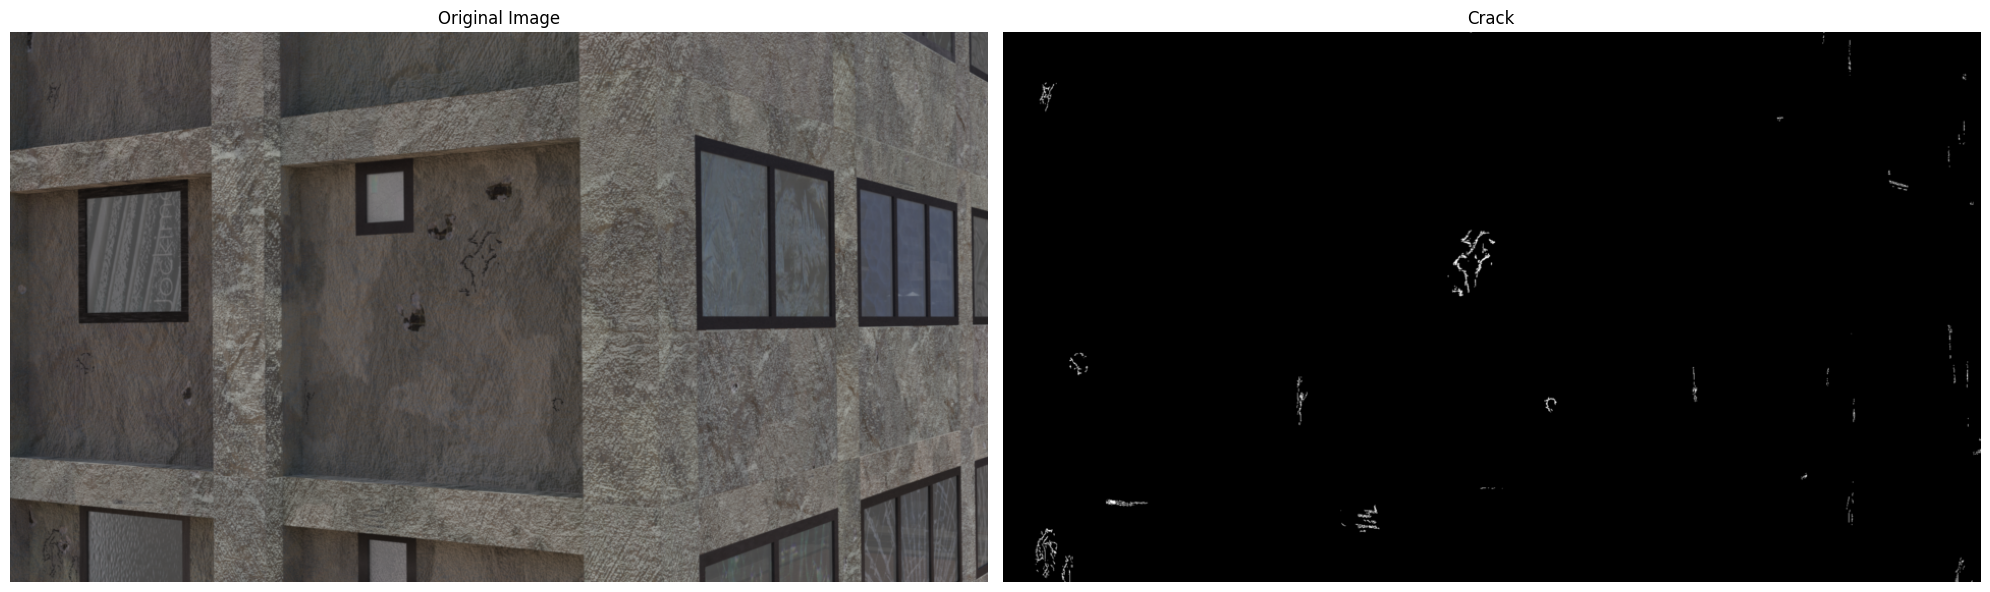

In [22]:
# 2.5 Visualise data
def visualize_sample(image, label):
    """Display the image and its 6 label masks."""
    label_names = ["Component", "Crack", "Spall", "Rebar", "Damage State", "Depth"]
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Show the original image
    print(image.shape)
    axes[0].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    # Show the label mask
    axes[1].imshow(label.permute(1, 2, 0), cmap='gray')  # Visualize label
    axes[1].set_title(label_names[1])
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

img_batch, label_batch = next(iter(train_loader))
visualize_sample(img_batch[0], label_batch[0])

In [23]:
# 3. Choose optimizer

criterion = nn.CrossEntropyLoss()  # Multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [25]:
# 4. Train model

epochs = 2

for epoch in range(1, epochs + 1):

    for batch_id, (data,target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad() # zero the gradients
        output = model(data)    # apply network (Same as model.forward(data))
        loss = criterion(output, target)

        loss.backward()       # compute gradients
        optimizer.step()      # update weights

         # Print loss and statistics of output/target
        print('Epoch%3d: zero_grad(): loss=%7.4f output_mean=%7.4f target_mean=%7.4f' %
              (epoch, loss.item(), output.mean().item(), target.mean().item()))

        # Convert the output tensor to a NumPy array and plot the image
        output_image = output[-1].cpu().detach().numpy()  # Get the first image in the batch
        output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

        # Convert from (C, H, W) to (H, W, C)
        output_image = np.transpose(output_image, (1, 2, 0))
        print(output_image.shape)

        # Display the output image (for visualization)
        plt.imshow(output_image)
        plt.title(f"Epoch {epoch} - Output Image")
        plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 446.12 MiB is free. Process 5107 has 14.30 GiB memory in use. Of the allocated memory 13.31 GiB is allocated by PyTorch, and 889.65 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)